<a href="https://colab.research.google.com/github/Mukolwe29/Mukolwe29/blob/main/Machine_Learning(KNN%2CANN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML

*Welcome to Machine Learning Housing Corp.! The task is to predict median house values in Californian districts, given a number of features from these districts.*



**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [ ]:
housing["median_income"].hist()

**Warning**: in the book, I did not use `pd.cut()`, instead I used the code below. The `pd.cut()` solution gives the same result (except the labels are integers instead of floats), but it is simpler to understand:

```python
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
```

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

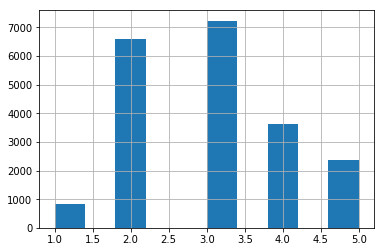

In [ ]:
housing["income_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Prepare the data for Machine Learning algorithms

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
print(type(housing_labels))

<class 'pandas.core.series.Series'>


In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [ ]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Transform the training set:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [ ]:
imputer.strategy

'median'

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that was introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). If you are using an older version of Scikit-Learn (<0.20), then you can import it from `future_encoders.py` instead.

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [ ]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features (again, we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Select a model and train it

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
print(type(housing_prepared))
print(housing_prepared.shape)
print(housing_prepared[0])
print(type(housing_labels))
print(housing_labels.shape)
print(housing_labels[0:4])

<class 'numpy.ndarray'>
(16512, 16)
[-1.15604281  0.77194962  0.74333089 -0.49323393 -0.44543821 -0.63621141
 -0.42069842 -0.61493744 -0.31205452 -0.08649871  0.15531753  1.
  0.          0.          0.          0.        ]
<class 'pandas.core.series.Series'>
(16512,)
17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
Name: median_house_value, dtype: float64


In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Cross Validation and Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.052574,0.001301,0.003768,0.000717,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.167826,0.001362,0.009517,0.000629,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.505532,0.002458,0.025149,0.001406,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.083672,0.001002,0.003109,0.000132,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.275359,0.001692,0.008840,0.000286,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.823414,0.001982,0.024308,0.000431,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.113032,0.003054,0.003010,0.000042,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.376960,0.004033,0.008667,0.000271,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.140749,0.005006,0.024175,0.000208,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.143770,0.001419,0.003175,0.000180,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a19024a58>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a190242e8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

# Present your solution to the test set

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927